In [1]:
from pathlib import Path
import pickle, gzip, math, os, time, shutil, matplotlib as mpl, matplotlib.pyplot as plt

In [2]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path("./data")
path_data.mkdir(exist_ok=True)
path_gz = path_data/"mnist.pkl.gz"

In [3]:
from urllib.request import urlretrieve

In [4]:
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [5]:
with gzip.open(path_gz) as f: (x_train, y_train), (x_valid, y_valid), _ = pickle.load(f, encoding='latin-1')

In [6]:
img_1 = x_train[0]

In [7]:
def chunk(x, n):
    for i in range(0, len(x), n):
        yield x[i: i+n]

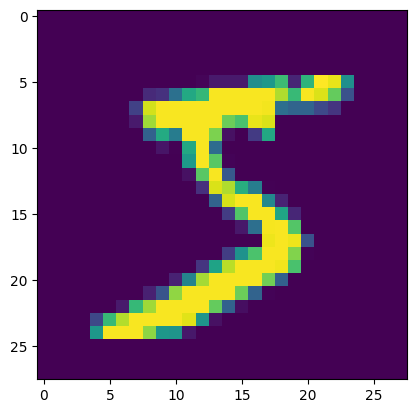

In [8]:
a = list(chunk(img_1, 28))
plt.imshow(a)

## islice

In [9]:
from itertools import islice

In [10]:
def list_to_2d(image_vector):
    it = iter(image_vector)
    return list(iter(lambda: list(islice(it, 28)), []))

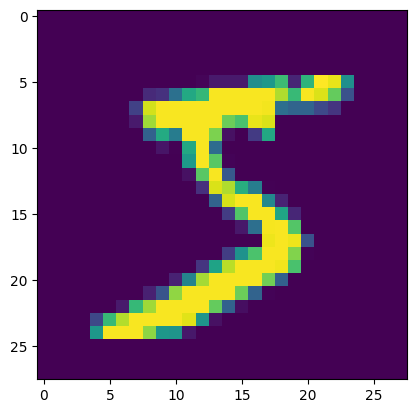

In [11]:
plt.imshow(list_to_2d(img_1))

## Matrix Class

In [12]:
class Matrix:
    def __init__(self, data): self.data=data
    def __getitem__(self, idxs): return self.data[idxs[0]][idxs[1]]
    def size(self): return (len(self.data), len(self.data[0]))

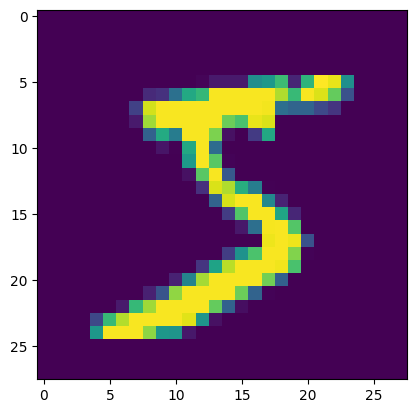

In [13]:
mat_1 = Matrix(list_to_2d(img_1))
plt.imshow(mat_1.data)

## Matmul

In [14]:
def matmul(a, b):
    d_i, d_k = a.size()
    d_k_, d_j = b.size()
    assert d_k == d_k_

    output = []
    
    for i in range(d_i):
        output.append([])
        for j in range(d_j):
            sum_over_k = sum([a[i, k] * b[k, j] for k in range(d_k)])
            output[i].append(sum_over_k)
    return Matrix(output)

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.1065826416015625, 0.33331298828125, 0.50579833984375, 1.134765625, 1.4051666259765625, 1.70062255859375, 2.3333892822265625, 2.7000579833984375, 2.7892608642578125, 2.540252685546875, 2.2837371826171875, 2.0879669189453125, 1.892486572265625, 2.3965301513671875, 2.0

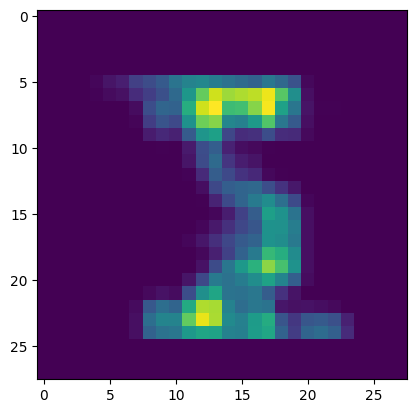

In [15]:
out = matmul(mat_1, mat_1)
print(out.data)
plt.imshow(out.data)